# Intro

**The selection of the most appropriate test is based on:**
- the number of variables of interest: **one**, **two** or **more than two** variables
- the variable type: **quantitative** or **qualitative**
- in case of a qualitative variable, the **number of groups** and whether they are **independent or paired** (i.e., dependent)
- whether you want the **parametric** or **nonparametric** version

**Non-parametric tests** don't make assumptions about the underlying distribution of the data focusing more on **ranks or medians** rather than means.

<img src='https://i.postimg.cc/VsB6HjWx/overview-statistical-tests.jpg'>

The pic above is from https://statsandr.com/blog/what-statistical-test-should-i-do/  
**In this notebook we go through all these tests from left to right.**  
**But before that we go through tests for normality and tests for equal variances**

Another useful link [Which plot is appropriate based on the type of data](https://www.data-to-viz.com/#explore)

# Initial Imports

In [32]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

# P value is the maximum significance level(a) at which we can't reject the null hypothesis.
# So we can only reject the null when a > p.
# a = 1-c(confidence level) 
# So we can only reject the null when c < 1-p.
def conclude(p, a):
    if p < a:
        print(f'The null hypothesis is rejected with {a} significance level')
    else:
        print(f"The null hypothesis can't be rejected with {a} significance level")

# Normality tests

Parametric tests assume that the distribution of the **sample means** is approximately normal.  There are 3 key scenarios:
1. **If the Population is normally distributed:**
    - When the population itself is normally distributed, the **sample means** will also be normally distributed, **regardless of the sample size**. 
2. **If the Population distribution is not normal or unknown but the Sample size is large (typically n>30):**
    - The CLT states that as the sample size increases, the distribution of the **sample means** approaches a normal distribution(**with mean = population mean, std = population std/sqrt(n)**), regardless of the population's distribution.
    - A common rule of thumb is that a sample size greater than 30 is large enough for the CLT to apply, making the distribution of the sample means approximately normal, even if the population is not normal.
3. **If the Population distribution is not normal or unknown and the Sample size is small (typically n<=30):**
    - In this case, run a **normality test** on the sample. If the sample data is normally distributed, you can still assume **the distribution of the sample means to be normal**, otherwise use a **non-parametric test**.

So we need **normality tests** in the 3-rd scenio, when the Population distribution is **not normal or unknown** and the Sample size is **small (typically n<=30).**

**Common Normality Tests:**
1. **Shapiro-Wilk Test** - scipy.stats.shapiro():  
One of the most commonly used tests for checking normality.
2. **Kolmogorov-Smirnov Test (K-S Test)** - scipy.stats.kstest(cdf='norm'):  
Compares the distribution of the sample data to a reference (normal) distribution. It’s sensitive to both the location and shape of the distribution, making it less reliable for small samples.
3. **Anderson-Darling Test** - scipy.stats.anderson(dist='norm'):  
Modification of the K-S test that gives **more weight to the tails** of the distribution. It is generally **more powerful than the K-S test**. Suitable for financial data where tail behavior is important.
4. **D’Agostino’s K-squared Test** - scipy.stats.normaltest():  
Checks for normality by **testing for skewness and kurtosis** in the distribution. It is useful when you want to check both the symmetry (skewness) and the tailedness (kurtosis) of the data.


**Assumptions:**
1. **Shapiro-Wilk Test**: The sample size is not too large (though it is still used for large samples).
2. **Kolmogorov-Smirnov Test (K-S Test)**: The sample should not be too small or large; it works best with moderate sample sizes.
3. **Anderson-Darling Test** - Suitable for moderate and large sample sizes. 
4. **D’Agostino’s K-squared Test** - The sample size should not be too small (recommended n>20).

**Hypothesis:**
- **Null Hypothesis (H₀):** The data follows a normal distribution.
- **Alternative Hypothesis (H₁):** The data does not follow a normal distribution.

**Conclusion:**
- Use **Shapiro-Wilk** for small sample sizes.
- Use **D’Agostino’s K-squared** or **Anderson-Darling** for larger sample sizes.
- Use **Kolmogorov-Smirnov** if you're comparing to a specific distribution (like normal).

/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


P value:  0.878300286770219
Fail to reject the null hypothesis: The data is normally distributed.

P value:  0.9874739854241917
Fail to reject the null hypothesis: The data is normally distributed.

P value:  0.7390562287714483
Fail to reject the null hypothesis: The data is normally distributed.

Fail to reject the null hypothesis: The data is normally distributed.


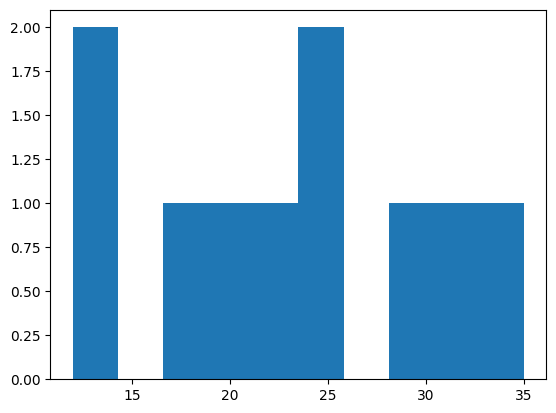

In [33]:
import matplotlib.pyplot as plt

# Data
data = [12, 14, 18, 19, 22, 24, 25, 30, 32, 35] # np.random.normal(10, 12, 100)
plt.hist(data)

# Shapiro-Wilk
stat, p1 = stats.shapiro(data)    
# K-S(if args not provided by default compares the data against the standard normal distribution(mean=0, std=1))
stat, p2 = stats.kstest(data, cdf='norm', args=(np.mean(data), np.std(data))) 
# D’Agostino’s K-squared
stat, p3 = stats.normaltest(data)  
# Anderson-Darling
result = stats.anderson(data, dist='norm')  
cv = result.critical_values[np.where(result.significance_level == 5)[0][0]]

# Conclusions
for p in [p1, p2, p3]:
    print('P value: ', p)
    if p > 0.05:
        print("Fail to reject the null hypothesis: The data is normally distributed.\n")
    else:
        print("Reject the null hypothesis: The data is not normally distributed.\n")
        
if result.statistic < cv:
    print("Fail to reject the null hypothesis: The data is normally distributed.")
else:
    print("Reject the null hypothesis: The data is not normally distributed.")

# Tests for Homogeneity(equality) of Variances

**Common Tests for Homogeneity of Variances:**
1. **Levene's Test** - scipy.stats.levene()
2. **Bartlett's Test**  - scipy.stats.bartlett()
3. **Brown-Forsythe Test** - scipy.stats.levene(center='median') - **uses the median instead of the mean**
4. **Fligner-Killeen Test** - scipy.stats.fligner() - **the most robust to non-normality**

**Assumptions for Homogeneity of Variance Tests:**
- Independence of observations within and across groups.
- For **Bartlett’s test**, the data **must be normally distributed**.
- For Levene's, Brown-Forsythe, and Fligner-Killeen, the data does **not have to be normally distributed**.

**Hypothesis:**
- **Null Hypothesis (H₀):** Variances are equal across groups.
- **Alternative Hypothesis (H₁):** Variances are not equal across groups.

**General Conclusion:**
- Use **Levene’s test** or **Brown-Forsythe test** when you’re unsure about normality.
- Use **Bartlett’s test** if you know the data is normally distributed.
- Use the **Fligner-Killeen test** if your data is significantly non-normal or if you are using non-parametric methods.

In [34]:
# Data
group1 = [10, 12, 14, 15, 17]
group2 = [10, 11, 13, 14, 16]
group3 = [8, 9, 10, 12, 15]

# Calculations
stat, p1 = stats.levene(group1, group2, group3)                  # Levene's test
stat, p2 = stats.bartlett(group1, group2, group3)                # Bartlett's test
stat, p3 = stats.levene(group1, group2, group3, center='median') # Brown-Forsythe test
stat, p4 = stats.fligner(group1, group2, group3)                 # Fligner-Killeen test

# Conclusions
for p in [p1, p2, p3, p4]:
    print('P value: ', p)
    if p > 0.05:
        print("Fail to reject the null hypothesis: Variances are equal.\n")
    else:
        print("Reject the null hypothesis: Variances are not equal.\n")

P value:  0.9744150206470972
Fail to reject the null hypothesis: Variances are equal.

P value:  0.955991660476931
Fail to reject the null hypothesis: Variances are equal.

P value:  0.9744150206470972
Fail to reject the null hypothesis: Variances are equal.

P value:  0.9707228836527247
Fail to reject the null hypothesis: Variances are equal.



# One-proportion test

One-proportion test is used to compare an **observed proportion** to an **expected proportion**, when the qualitative variable has **only two categories**.

## Example 1

A company claims that **70%** of their customers are satisfied with their service. To verify this claim, a survey of **200 customers** shows that **140 are satisfied**. Is there enough evidence at the **5% significance level** to reject the company's claim?

**Hypotheses:**
- **Null Hypothesis (H0)**: The true proportion of satisfied customers is 0.70.
- **Alternative Hypothesis (H1)**: The true proportion of satisfied customers is not 0.70 (two-sided test).

In [35]:
# Data
successes = 140  # Number of satisfied customers
n = 200         # Total number of customers surveyed
p_null = 0.70   # Hypothesized proportion
a = 0.05        # Significance level

# Calculations
z, p = sm.stats.proportions_ztest(count=successes, nobs=n, value=p_null, alternative='two-sided')
print(f"Z-statistic: {z}")
print(f"P-value: {p}")

# Conclusions
conclude(p, a)

Z-statistic: 0.0
P-value: 1.0
The null hypothesis can't be rejected with 0.05 significance level


## Example 2 
From [zedstatistics](https://youtu.be/bh_5Yr3YjO0?si=JYrBiVI8suk-7mEK)

Gigi's Pizza regularly surveys its customers. On the basis of these surveys, the management of the chain claims that **at least 75%** of its customers rate the food as excellent. A consumer testing service wants to examine the claim by asking **460 customers** to rate the food. **71%** rated the food as excellent. Is there enough evidence at the (a) **5%** and (b) **1%** level of significance to reject management's claim?

**Hypotheses**
- **Null Hypothesis (H0)**: The true proportion is equal to **0.75**.
- **Alternative Hypothesis (H1)**: The true proportion is **less than 0.75**(one-tailed test).

In [36]:
# Data
successes = 460*0.71  # Number of satisfied customers
n = 460         # Total number of customers surveyed
p_null = 0.75   # Hypothesized proportion
a_s = [0.05, 0.01]     # Significance level

# Calculations
z, p = sm.stats.proportions_ztest(count=successes, nobs=n, value=p_null, alternative='smaller')
print(f"Z-statistic: {z}")
print(f"P-value: {p}")

# Conclusions
for a in a_s:
    conclude(p, a)

Z-statistic: -1.890648236132947
P-value: 0.0293356583298111
The null hypothesis is rejected with 0.05 significance level
The null hypothesis can't be rejected with 0.01 significance level


# Chi-square goodness of fit test

The Chi-Square Goodness of Fit test is used when you want to compare **observed categorical data** with **expected data** under a specific hypothesis. It helps determine if a sample comes from a population with a specific distribution.

## Example 1
A die is rolled **60 times**, and the following outcomes are observed: **10 ones**, **8 twos**, **12 threes**, **15 fours**, **7 fives**, and **8 sixes**. Is the die fair at a **5% significance level**?

**Hypotheses:**
- **Null Hypothesis (H0)**: The die **is fair**, i.e., each outcome has an equal probability of **1/6**.
- **Alternative Hypothesis (H1)**:The die **is not fair**, i.e., the outcomes do not occur with equal probability.

In [37]:
# Data
observed = [10, 8, 12, 15, 7, 8] # Observed frequencies
total = sum(observed)            # Total rolls
expected = [total/len(observed)] * len(observed) # Expected frequencies if the die is fair
a = 0.05                         # Significance Level

# Calculations
chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Chi-square statistic: 4.6000000000000005
P-value: 0.4666162741153308
The null hypothesis can't be rejected with 0.05 significance level


## Example 2
A survey was conducted to check the distribution of fruit preferences **among 100 people**. The observed frequencies were: **apples (30)**, **bananas (20)**, **oranges (25)**, and **grapes (25)**. The null hypothesis is that each fruit is equally preferred. Test at the **5% significance level**.

**Hypotheses:**
- **Null Hypothesis (H0)**: The proportions of preference for all fruits are equal.
- **Alternative Hypothesis (H1)**: The proportions of preference for the fruits are not equal.

In [38]:
# Data
observed = [30, 20, 25, 25]      # Observed frequencies
total = sum(observed)         
expected = [total/len(observed)] * len(observed) # Expected frequencies (assuming equal preference for all fruits)
a = 0.05                         # Significance Level

# Calculations
chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Chi-square statistic: 2.0
P-value: 0.5724067044708798
The null hypothesis can't be rejected with 0.05 significance level


# One-sample Student's t-test(population variance is known)

- This is actually **not a Student's t-test** but a **z-test** when the **population variance is known**. 
- It's used to test if the sample mean differs from a known population mean when the population variance is provided.

[Detailed explanation of what's going on behind One-sample t-test, z-test in just **2 PAGES**](https://github.com/Artur-Arstamyan/Statistics/blob/main/One-sample%20t-test%2C%20z-test.pdf)

## Example 1

A machine is supposed to fill bottles with **500 ml of liquid**. The known population variance is **4 ml²**. A sample of **30 bottles** has an average fill of **498 ml**. Test at the **5% significance level** whether the machine is filling the bottles with the correct amount.

**Hypotheses:**
- **Null Hypothesis (H0)**: The mean amount of liquid filled by the machine is **500 ml**.
- **Alternative Hypothesis (H1)**: The mean amount of liquid filled by the machine is not **500 ml(two-sided test)**.

In [39]:
# Data
sample_mean = 498  # Sample mean
pop_mean = 500     # Population mean
pop_var = 4        # Population variance
n = 30             # Sample size

# Calculations
standard_error = np.sqrt(pop_var/n) # std of the distribution of the sample means
z_stat = (sample_mean - pop_mean)/standard_error # the z-statistic
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat))) # p-value for a two-tailed test
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

# Conclusions
conclude(p_value, a)

Z-statistic: -5.477225575051661
P-value: 4.3204630539861455e-08
The null hypothesis is rejected with 0.05 significance level


# One-sample Student's t-test(population variance is unknown)

[Detailed explanation of what's going on behind One-sample t-test, z-test in just **2 PAGES**](https://github.com/Artur-Arstamyan/Statistics/blob/main/One-sample%20t-test%2C%20z-test.pdf)

## Example 1

A factory claims that their batteries have a mean lifespan of **100 hours**. A sample of **10 batteries** has a mean lifespan of **98 hours** with a **standard deviation of 5 hours**. Test at the **5% significance level** whether the average battery lifespan is significantly different from 100 hours.

**Hypotheses:**
- **Null Hypothesis (H0)**: The **mean** battery lifespan is **100 hours**.
- **Alternative Hypothesis (H1)**: The mean battery lifespan **is not** 100 hours(two-sided test).

In [40]:
# Data
sample_data = np.array([95, 102, 104.91498676, 102, 97.80022694, 102.9845537, 87, 95.05836667, 95, 98.168116]) # Sample of 10 batteries
sample_size = 10
popmean = 100  # Claimed mean lifespan
a = 0.05   # Significance level

# Calculations
# Doing ourselves
sample_mean = sample_data.mean()
sample_std = sample_data.std()
se = sample_std/np.sqrt(sample_size) # std of the distribution of the sample means
t_stat = (sample_mean-popmean)/se    # the t-statistic
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat))) # p-value for a two-tailed test
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
# Using scipy.stats
t_stat, p_value = stats.ttest_1samp(sample_data, popmean=popmean)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Conclusions
conclude(p_value, a)

T-statistic: -1.263565905769756
P-value: 0.20638587735688851
T-statistic: -1.1987238707898367
P-value: 0.2612450691309508
The null hypothesis can't be rejected with 0.05 significance level


# One-sample Wilcoxon Signed-Rank test

- The One-sample Wilcoxon signed-rank test is a **non-parametric alternative** to the One-sample t-test. 
- It’s used when the data **do not follow a normal distribution**, but you want to test whether **the median** of a sample differs from a hypothesized value.

## Example 1

A doctor claims that a new drug reduces blood pressure. The differences in blood pressure (before - after) for **10 patients** are: 5, 3, 6, 2, 4, 1, 3, 4, 2, 3. Test at the **5% significance level** if the drug reduces blood pressure.

**Hypotheses:**
- **Null Hypothesis (H0)**: The **median** of the differences is zero (no effect).
- **Alternative Hypothesis (H1)**: The **median** of the differences is greater than zero (drug reduces blood pressure).(one-sided)

In [41]:
# Data
differences = [5, 3, 6, 2, 4, 1, 3, 4, 2, 3]  # Differences in blood pressure
a = 0.05                                      # Significance level

# Calculations
w_stat, p_value = stats.wilcoxon(differences, alternative='greater') # Perform One-sample Wilcoxon signed-rank test
print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Wilcoxon statistic: 55.0
P-value: 0.0009765625
The null hypothesis is rejected with 0.05 significance level


# McNemar’s test

- McNemar’s test is used for **paired nominal data** (i.e., data with two categories, like yes/no, success/failure) to test if there is a significant change or difference in the **proportions before and after** an intervention or **between two related samples** (e.g., repeated measures).  
- It is typically used in **pre-post studies** or studies where participants act as their **own controls** (e.g., testing a treatment's effectiveness on the same group of people at two points in time).
- The test **is typically used** when the sample size is large enough. If the data has **cells** with very small counts (especially **less than 5**), it’s better to use **an exact version of McNemar's test** (binomial distribution rather than chi-square approximation).


# Example 1

You want to test whether a new drug significantly reduces the number of smokers at the **5% significance level**. You ask **100 people** before and after taking the drug whether they smoke or not. The results are as follows:


|             |   After: Yes |   After: No |
|:------------|-------------:|------------:|
| Before: Yes |           50 |          30 |
| Before: No  |           10 |          10 |

**Hypotheses:**
- **Null Hypothesis (H0)**: The proportions of smokers before and after the treatment **are the same** (no effect of the drug).
- **Alternative Hypothesis (H1)**: The proportions of smokers before and after the treatment **are different** (the drug has an effect).


In [42]:
# Data
table = [[50, 30], [10, 10]] # Contingency table 
a = 0.05                     # Signifance level

# Calculations
from statsmodels.stats.contingency_tables import mcnemar
result = mcnemar(table, exact=False, correction=True) # McNemar test
print(f'McNemar’s Test statistic: {result.statistic}')
print(f'P-value: {result.pvalue}')

# Conclusion
conclude(result.pvalue, a)

McNemar’s Test statistic: 9.025
P-value: 0.002663119259138558
The null hypothesis is rejected with 0.05 significance level


# Cochran's Q Test

- Cochran’s Q test is used when you have **three or more** related samples of binary (yes/no) data and you want to determine if there is a difference in proportions across the groups.
- It’s an **extension of the McNemar test** for more than two related groups.
- The same individual is measured across different groups, but observations between individuals must be independent.

## Example 1

A researcher tests three different marketing strategies on the same group of 10 customers to see if there is any difference in effectiveness (whether they made a purchase or not) at the **5% significance level**. The responses (1 = purchase, 0 = no purchase) are:

| Customer    |   Strategy 1 | Strategy 2  | Strategy 3 |
|:------------|-------------:|------------:|-----------:|
| 1           |           1  |          0  |       1    |
| 2           |           1  |          1  |       1    |
| 3           |           0  |          0  |       0    |
| ...         |          ... |        ...  |     ...    |
| 10          |           1  |          1  |    0       |

**Hypotheses:**
- **Null Hypothesis (H0)**:  The proportion of purchases is the same across all three strategies.
- **Alternative Hypothesis (H1)**: The proportion of purchases differs between at least two strategies.

In [43]:
# Data
data = pd.DataFrame({
    'Strategy 1': [1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
    'Strategy 2': [0, 1, 0, 1, 1, 0, 0, 1, 0, 1],
    'Strategy 3': [1, 1, 0, 0, 1, 1, 0, 1, 1, 0]
})
a = 0.05                               # Signifance level

# Calculations
result = sm.stats.cochrans_q(data.values.T) # Cochran's Q test
print(f'Cochran’s Q statistic: {result.statistic}')
print(f'P-value: {result.pvalue}')

# Conclusion
conclude(result.pvalue, a)

Cochran’s Q statistic: 15.092307692307692
P-value: 0.08843144940176706
The null hypothesis can't be rejected with 0.05 significance level


# Fisher's Exact Test 

- Fisher’s exact test is used to determine if there are non-random associations between **two categorical variables** in a **2x2 contingency table**, especially when sample sizes are small.
- It’s an **alternative** to the **chi-square test of independence**(only when contingency table is 2x2) for small samples (when there is a **cell** having an expected frequency **less than 5**).

## Example 1

You want to test whether gender influences job acceptance at the **5% significance level**. The data is:

|        |   Accepted |   Rejected |
|:-------|-----------:|-----------:|
| Male   |          5 |         15 |
| Female |         10 |          5 |

**Hypotheses:**
- **Null Hypothesis (H0)**:  There is no association between gender and job acceptance.
- **Alternative Hypothesis (H1)**: There is an association between gender and job acceptance.

In [44]:
# Data
table = [[5, 15], [10, 5]] # Contingency table
a = 0.05                   # Signifance level

# Calculations
oddsratio, p_value = stats.fisher_exact(table, alternative='two-sided') # Fisher's Exact Test
print(f'Odds Ratio: {oddsratio}')
print(f'P-value: {p_value}')

# Conclusion
conclude(p_value, a)

Odds Ratio: 0.16666666666666666
P-value: 0.019226750261233022
The null hypothesis is rejected with 0.05 significance level


# Chi-Square Test of Independence

- The Chi-Square Test of Independence is used to determine if there is a significant association between **two categorical variables** in a contingency table. 
- It can be used **both when there are 2 groups** in each category **and when there are more than 2 groups** in each category.
- It is typically used when sample sizes are **larger** and expected frequencies are **5 or more in each cell**.
- We can use Fisher's Exact Test when both **there is an expected frequency less than 5** and **there are exactly 2 groups** in each category.


# Example 1

You want to know if there is an association between people’s **preferred mode of transportation** (car, bus, bike) and their **region** (urban, suburban, rural) at the **5% significance level**. The data is:

|          |   Car |   Bus | Bike  |
|:---------|------:|------:|------:|
| Urban    |    30 |    50 |     20|
| Suburban |    40 |    20 |10     |
| Rural    |    50 |    10 |20     |


**Hypotheses:**
- **Null Hypothesis (H0)**:  There is no association between mode of transportation and region.
- **Alternative Hypothesis (H1)**: There is an association between mode of transportation and region.

In [45]:
# Data
a = 0.05        # Signifance level
table = np.array([[30, 50, 20],
                  [40, 20, 10],
                  [50, 10, 20]])

# Calculations
chi2, p, dof, expected = stats.chi2_contingency(table) # Chi-square test of independence
print(f'Chi-square Statistic: {chi2}')
print(f'P-value: {p}')
print(f'Degrees of Freedom: {dof}')
print('Expected frequencies:')
print(expected)

# Conclusion
conclude(p, a)

Chi-square Statistic: 33.50446428571429
P-value: 9.415664802819671e-07
Degrees of Freedom: 4
Expected frequencies:
[[48.  32.  20. ]
 [33.6 22.4 14. ]
 [38.4 25.6 16. ]]
The null hypothesis is rejected with 0.05 significance level


# Student’s t-test for Two Independent Samples

- The Student’s t-test for two independent samples is used to determine if there is a **significant difference** between the means of **two independent groups** (e.g., comparing test scores of males and females).
- The data in each group should be **approximately normally distributed**.
- The **variances of the two groups** should be **equal** (homogeneity of variance).


## Example 1

Suppose we want to test whether there is a significant difference in the **test scores between two groups of students**: Group A and Group B at the **5% significance level**.

Group A (n = 8) - [85, 88, 75, 89, 90, 93, 95, 85]   
Group B (n = 8) - [78, 82, 75, 80, 85, 87, 84, 81]

**Hypotheses:**
- **Null Hypothesis (H0)**:  The means of the two groups are equal.
- **Alternative Hypothesis (H1)**: The means of the two groups are different.

In [46]:
# Data
group_A = [85, 88, 75, 89, 90, 93, 95, 85]
group_B = [78, 82, 75, 80, 85, 87, 84, 81]
a = 0.05        # Signifance level

# Calculations
t_stat, p_value = stats.ttest_ind(group_A, group_B) # Perform independent two-sample t-test
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

T-statistic: 2.334234060382259
P-value: 0.03499868375429103
The null hypothesis is rejected with 0.05 significance level


# Welch’s t-test for Two Independent Samples 

- Welch's t-test is used to compare the means of two independent samples **when the variances of the two groups are unequal**.
- It is a **modification of the Student's t-test** that doesn't assume equal variances.
- The data in each group should be **approximately normally distributed**.

## Example 1

Using Example 1 of the Student’s t-test for Two Independent Samples, we suspect that the variances in Group A and Group B are unequal at the **5% significance level**.

**Hypotheses:**
- **Null Hypothesis (H0)**:  The means of the two groups are equal.
- **Alternative Hypothesis (H1)**: The means of the two groups are different.

In [47]:
# Data
group_A = [85, 88, 75, 89, 90, 93, 95, 85]
group_B = [78, 82, 75, 80, 85, 87, 84, 81]
a = 0.05        # Signifance level

# Calculations
t_stat, p_value = stats.ttest_ind(group_A, group_B, equal_var=False) # Perform Welch's t-test (setting equal_var to False)
print(f"Welch’s T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Welch’s T-statistic: 2.334234060382259
P-value: 0.03804312983947011
The null hypothesis is rejected with 0.05 significance level


# Mann-Whitney U Test

- The Mann-Whitney U test is a **non-parametric test** used to determine if there is a difference in the **distribution of two independent samples**. 
- It assesses whether one group tends to **have higher or lower** values than the other by **comparing the ranks of the data** across groups.
- It is used when **the assumption of normality is not met**.
- The data can be **ordinal or continuous**, but does not need to be normally distributed.

## Example 1

Let’s say in **the Example 1 of the Student’s t-test for Two Independent Samples** the test scores in Group A and Group B are **not normally distributed**, and we want to test if there’s a difference in the distribution between these two groups at the **5% significance level**.

**Hypotheses:**
- **Null Hypothesis (H0)**:  The distributions of the two groups are the same.
- **Alternative Hypothesis (H1)**: The distributions of the two groups are different.

In [48]:
# Data
group_A = [85, 88, 75, 89, 90, 93, 95, 85]
group_B = [78, 82, 75, 80, 85, 87, 84, 81]
a = 0.05        # Signifance level

# Calculations
u_stat, p_value = stats.mannwhitneyu(group_A, group_B, alternative='two-sided') # Perform Mann-Whitney U test
print(f"Mann-Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Mann-Whitney U statistic: 53.5
P-value: 0.026856695507524397
The null hypothesis is rejected with 0.05 significance level


# Student’s t-test for Paired Samples(Paired t-test)

- The paired t-test is used to compare the means of **two related(dependant) groups** (e.g., pre-test and post-test scores for the same group of individuals).
- The difference between paired observations should be **normally distributed**.

## Example 1

A group of **10 students** took a test before and after attending a training session. We want to test whether the training had a significant effect on their scores at the **5% significance level**.

Before (n = 10) - [78, 85, 88, 92, 79, 81, 84, 89, 87, 85]   
After (n = 10)  - [85, 90, 92, 94, 85, 88, 90, 91, 93, 89]

**Hypotheses:**
- **Null Hypothesis (H0)**:  The mean difference between the two related groups is zero.
- **Alternative Hypothesis (H1)**: The mean difference between the two related groups is not zero.

In [49]:
# Data
before = [78, 85, 88, 92, 79, 81, 84, 89, 87, 85]
after  = [85, 90, 92, 94, 85, 88, 90, 91, 93, 89]
a = 0.05        # Signifance level

# Calculations
t_stat, p_value = stats.ttest_rel(before, after) # Perform paired t-test
print(f"Paired T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Paired T-statistic: -8.362537822632042
P-value: 1.5507965854085464e-05
The null hypothesis is rejected with 0.05 significance level


### Note
**T-test on two related groups is same as One-sample t-test on the differences between those groups with popmean=0.**

In [50]:
# Calculations
t_stat, p_value = stats.ttest_1samp(np.array(before)-np.array(after), popmean=0) # Perform One-sample t-test
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

T-statistic: -8.362537822632042
P-value: 1.5507965854085464e-05
The null hypothesis is rejected with 0.05 significance level


# Wilcoxon Signed Rank Test

- The Wilcoxon Signed Rank test is a **non-parametric alternative to the paired t-test**
- It is used when the differences between paired samples are **not normally distributed**.

## Example 1

Let’s say in the Example 1 of Paired t-test the **differences** between the test scores before and after training **are not normally distributed**, so we want to use **the Wilcoxon Signed Rank test** instead.

**Hypotheses:**
- **Null Hypothesis (H0)**:  The median difference between the two related groups is zero.
- **Alternative Hypothesis (H1)**: The median difference between the two related groups is not zero.

In [51]:
# Data
before = [78, 85, 88, 92, 79, 81, 84, 89, 87, 85]
after = [85, 90, 92, 94, 85, 88, 90, 91, 93, 89]
a = 0.05        # Signifance level

# Calculations
w_stat, p_value = stats.wilcoxon(before, after) # Perform Wilcoxon Signed Rank test
print(f"Wilcoxon Signed Rank statistic: {w_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Wilcoxon Signed Rank statistic: 0.0
P-value: 0.001953125
The null hypothesis is rejected with 0.05 significance level


### Note
**Wilcoxon Signed Rank Test on two related groups is same as One-sample Wilcoxon Signed Rank Test on the differences between those groups.**

In [52]:
# Calculations
w_stat, p_value = stats.wilcoxon(np.array(before)-np.array(after)) # Perform One-sample Wilcoxon signed-rank test
print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Wilcoxon statistic: 0.0
P-value: 0.001953125
The null hypothesis is rejected with 0.05 significance level


# One-way ANOVA

- One-way ANOVA is used to determine if there are **statistically significant** differences between the means of **three or more independent groups**. 
- It **extends the t-test** to more than two groups.
- The data in each group should be **normally distributed**.
- The variances of the groups should be approximately equal (**homoscedasticity**).

I have [another notebook](https://www.kaggle.com/code/arthurarstamyan/one-way-two-way-anova) about **One-way** and **Two-way ANOVAs** with **more examples, explanations and functions** that calculate **F statistic** and create **ANOVA table** .

## Example 1

Suppose we want to test whether there is a difference in the **average test scores** of students from **three** different teaching methods at the **5% significance level**.

Method 1 (n = 10) | 85, 88, 75, 89, 90, 93, 95, 85, 91, 87 |  
Method 2 (n = 10) | 78, 82, 75, 80, 85, 87, 84, 81, 79, 80 |  
Method 3 (n = 10) | 92, 94, 88, 90, 85, 87, 88, 92, 89, 90 |

**Hypotheses:**
- **Null Hypothesis (H0)**:  The means of the three groups are equal.
- **Alternative Hypothesis (H1)**: At least one group mean is different.

In [53]:
# Data
df = pd.DataFrame({'Method_1': [85, 88, 75, 89, 90, 93, 95, 85, 91, 87],
                   'Method_2': [78, 82, 75, 80, 85, 87, 84, 81, 79, 80],
                   'Method_3': [92, 94, 88, 90, 85, 87, 88, 92, 89, 90]})
a = 0.05        # Signifance level

# Calculations
f_stat, p_value = stats.f_oneway(df['Method_1'], df['Method_2'], df['Method_3']) # Perform one-way ANOVA
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

F-statistic: 11.75562913907285
P-value: 0.00021265239960759433
The null hypothesis is rejected with 0.05 significance level


# Welch’s ANOVA

- Welch’s ANOVA is a **non-parametric version of one-way ANOVA** used when **the assumption of equal variances is violated**. 
- It compares the means of **three or more independent groups** without assuming equal variances.
- The data in each group should be **normally distributed**.

## Example 1

Suppose we suspect that the variances between the groups in the Example 1 of One-way ANOVA are unequal.

**Hypotheses:**
- **Null Hypothesis (H0)**:  The means of the three groups are equal.
- **Alternative Hypothesis (H1)**: At least one group mean is different.

In [ ]:
!pip install pingouin

In [63]:
# Data
df = pd.DataFrame({'Method_1': [85, 88, 75, 89, 90, 93, 95, 85, 91, 87],
                   'Method_2': [78, 82, 75, 80, 85, 87, 84, 81, 79, 80],
                   'Method_3': [92, 94, 88, 90, 85, 87, 88, 92, 89, 90]})
df_long = df.melt(var_name='Method', value_name='Score') # Prepare data in long format
a = 0.05        # Signifance level

# Calculations
import pingouin as pg
welch_anova = pg.welch_anova(dv='Score', between='Method', data=df_long) # Perform Welch's ANOVA
_, _, _, f_stat, p_value, _ = welch_anova.iloc[0]
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

F-statistic: 17.468263500900147
P-value: 7.78352993037563e-05
The null hypothesis is rejected with 0.05 significance level


# Kruskal-Wallis Test

- The Kruskal-Wallis test is a **non-parametric alternative to one-way ANOVA** used when the data is **not normally distributed**. 
- It tests whether the distributions of **three or more independent groups** are the same.

## Example 1

Suppose in the Example 1 of One-way ANOVA the test scores are **not normally distributed**, and we want to use **the Kruskal-Wallis test** to compare the groups.

**Hypotheses:**
- **Null Hypothesis (H0)**: The distributions of the three groups are the same.
- **Alternative Hypothesis (H1)**: The distributions of at least one group are different.

In [55]:
# Data
df = pd.DataFrame({'Method_1': [85, 88, 75, 89, 90, 93, 95, 85, 91, 87],
                   'Method_2': [78, 82, 75, 80, 85, 87, 84, 81, 79, 80],
                   'Method_3': [92, 94, 88, 90, 85, 87, 88, 92, 89, 90]})
df_long = df.melt(var_name='Method', value_name='Score') # Prepare data in long format
a = 0.05        # Signifance level

# Calculations
h_stat, p_value = stats.kruskal(df['Method_1'], df['Method_2'], df['Method_3']) # Perform Kruskal-Wallis test
print(f"Kruskal-Wallis H statistic: {h_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Kruskal-Wallis H statistic: 14.538285970015677
P-value: 0.0006967088278861448
The null hypothesis is rejected with 0.05 significance level


# Repeated Measures ANOVA

- Repeated measures ANOVA is used to determine if there are differences in the means across **three or more related groups**.
- It is used when the **same subjects are measured multiple times** (e.g., pre-test, post-test, follow-up).
- The variances of the differences between all combinations of groups should be equal(**Sphericity**).
- The differences between related groups should be **normally distributed**.

## Example 1

A group of **10 students** took a test **before**, **immediately after**, and **three months after** a training session. We want to test if there is a significant difference in their scores over time.

Before (n = 10) | 78, 85, 88, 92, 79, 81, 84, 89, 87, 85 |  
After (n = 10) | 85, 90, 92, 94, 85, 88, 90, 91, 93, 89 |  
3 Months After (n = 10) | 88, 93, 95, 92, 87, 89, 92, 94, 91, 90 |

**Hypotheses:**
- **Null Hypothesis (H0)**: The means of the three time points are equal.
- **Alternative Hypothesis (H1)**: At least one time point mean is different.

In [56]:
# Data 
df_rm = pd.DataFrame({'Before': [78, 85, 88, 92, 79, 81, 84, 89, 87, 85],
                      'After': [85, 90, 92, 94, 85, 88, 90, 91, 93, 89],
                      'Months_After': [88, 93, 95, 92, 87, 89, 92, 94, 91, 90]})
a = 0.05        # Signifance level

# Calculations
import pingouin as pg
rm_anova = pg.rm_anova(df_rm) # Perform repeated measures ANOVA
_, _, _, f_stat, p_value, _, _ = rm_anova.iloc[0]
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

F-statistic: 42.39167862266845
P-value: 1.5493422147807488e-07
The null hypothesis is rejected with 0.05 significance level


# Friedman Test

- The Friedman test is a **non-parametric alternative to repeated measures ANOVA.**
- It used when the data is **not normally distributed**. 
- It tests if there are differences in the distribution across **three or more related groups**.

## Example 1

Let’s say the test scores **before**, **immediately after***, and **three months after** the training session are **not normally distributed**. We want to use **the Friedman test** to analyze the differences.

**Hypotheses:**
- **Null Hypothesis (H0)**: The distributions of the three time points are the same.
- **Alternative Hypothesis (H1)**: The distributions of at least one time point are different.

In [57]:
# Data 
df_rm = pd.DataFrame({'Before': [78, 85, 88, 92, 79, 81, 84, 89, 87, 85],
                      'After': [85, 90, 92, 94, 85, 88, 90, 91, 93, 89],
                      'Months_After': [88, 93, 95, 92, 87, 89, 92, 94, 91, 90]})
a = 0.05        # Signifance level

# Calculations
friedman_stat, p_value = stats.friedmanchisquare(df_rm['Before'], df_rm['After'], df_rm['Months_After']) # Perform Friedman test
print(f"Friedman statistic: {friedman_stat}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Friedman statistic: 15.435897435897449
P-value: 0.00044477202166078673
The null hypothesis is rejected with 0.05 significance level


# Pearson Correlation
- Pearson correlation is used to measure the **linear relationship** between **two continuous variables**. 
- It ranges from **-1** (**perfect negative** linear correlation) to **1** (**perfect positive** linear correlation), with **0** indicating **no** linear correlation.
- Both variables should be **normally distributed**.
- The variance of one variable should be constant for all values of the other variable (**homoscedasticity**).

## Example 1

Suppose you want to determine the relationship between **students' study time** (hours per week) and their **exam scores**.

|   Study Time (hrs) |   Exam Score |
|------------------:|-------------:|
|                 5 |           60 |
|                10 |           65 |
|                15 |           70 |
|                20 |           75 |
|                25 |           80 |
|                30 |           85 |
|                35 |           90 |
|                40 |           95 |

**Hypotheses:**
- **Null Hypothesis (H0)**: There is no linear correlation between study time and exam score.
- **Alternative Hypothesis (H1)**:  There is a linear correlation between study time and exam score.

In [58]:
# Data
study_time = np.array([5, 10, 15, 20, 25, 30, 35, 40])
exam_scores = np.array([60, 65, 70, 75, 80, 85, 90, 95])
a = 0.05        # Signifance level

# Calculations
corr, p_value = stats.pearsonr(study_time, exam_scores) # Pearson correlation
print(f"Pearson Correlation Coefficient: {corr}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Pearson Correlation Coefficient: 1.0
P-value: 0.0
The null hypothesis is rejected with 0.05 significance level


# Spearman’s Rank Correlation

- Spearman’s rank correlation is a **non-parametric test** used to assess the relationship between **two variables**. 
- It’s often used when data do not meet the assumptions required for Pearson correlation, such as **normality or linearity**.
- It measures the **strength and direction** of the **monotonic relationship** (whether increasing or decreasing) between two ranked variables.

## Example 1

Suppose we want to examine **the relationship** between students' **ranks in their school grades** and their **ranks in extracurricular achievements**.

|   Grade Rank |   Activity Rank |
|------------------:|-------------:|
|                 1 |           2 |
|                2 |           1 |
|                3 |           4 |
|                4 |           3 |
|                5 |           6 |
|                6 |            5|
|                7 |            8|
|                8 |           7 |

**Hypotheses:**
- **Null Hypothesis (H0)**: There is **no monotonic correlation** between grade rank and activity rank.
- **Alternative Hypothesis (H1)**:  There **is a monotonic correlation** between grade rank and activity rank.

In [59]:
# Data
grade_rank = np.array([1, 2, 3, 4, 5, 6, 7, 8])
activity_rank = np.array([2, 1, 4, 3, 6, 5, 8, 7])
a = 0.05        # Signifance level

# Calculations
spearman_corr, p_value = stats.spearmanr(grade_rank, activity_rank) # Spearman's rank correlation
print(f"Spearman's Rank Correlation Coefficient: {spearman_corr}")
print(f"P-value: {p_value}")

# Conclusion
conclude(p_value, a)

Spearman's Rank Correlation Coefficient: 0.9047619047619048
P-value: 0.0020082755054294677
The null hypothesis is rejected with 0.05 significance level


# Multiple Linear Regression

- Multiple linear regression is used to **model the relationship** between **one dependent variable** (continuous) and **two or more independent variables** (continuous or categorical). 
- It aims **to predict** the dependent variable based on the independent variables.
- The observations are independent of each other.
- The variance of errors is constant across all levels of the independent variables(**Homoscedasticity**).
- The residuals (errors) should follow a **normal distribution**.
- The independent variables should not be too highly correlated with each other(**No multicollinearity**).

## Example 1

Suppose we want to **predict the exam score** of students based on their **study time** (hours per week) and **the number of assignments** they completed.

|   Study Time (hrs)|   Assignments|   Exam Score |
|------------------:|-------------:|-------------:|
|                 5 |            2 |           60 |
|                10 |            3 |           65 |
|                15 |            4 |           70 |
|                20 |            5 |           75 |
|                25 |            6 |           80 |
|                30 |            7 |           85 |
|                35 |            8 |           90 |
|                40 |            9 |           95 |

**Hypotheses:**
- **Null Hypothesis (H0)**: The coefficients for the independent variables(study time and assignments) are 0 (i.e., they do not predict exam scores).
- **Alternative Hypothesis (H1)**: At least one of the coefficients is not 0 (i.e., they do predict exam scores).

In [60]:
# Data
study_time = np.array([5, 10, 15, 20, 25, 30, 35, 40])
assignments = np.array([2, 3, 4, 5, 6, 7, 8, 9])
exam_scores = np.array([60, 65, 70, 75, 80, 85, 90, 95])
X = np.column_stack((study_time, assignments)) # Independent variables
X = sm.add_constant(X)
y = exam_scores # Dependent variable

# Calculations
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.449e+29
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           4.17e-88
Time:                        12:56:30   Log-Likelihood:                 235.85
No. Observations:                   8   AIC:                            -467.7
Df Residuals:                       6   BIC:                            -467.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.9412   1.76e-14   1.59e+15      0.0

/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


- The p-values for **StudyTime** and **Assignments** are 0.000, **so we reject the null hypothesis for both**, meaning that **both variables are significant predictors of exam score**.
- The overall **F-statistic** is significant (p < 0.05), indicating that the model as a whole fits the data well.

# Binary Logistic Regression

- Binary logistic regression is used to model the **relationship** between a **binary dependent variable** (e.g., success/failure, pass/fail, yes/no) and **one or more independent variables.**
- The **output** is the **probability of the dependent variable being 1** (success).
- Each observation is independent of the others.
- **No multicollinearity** among the independent variables.

## Example 1

Suppose we want to predict whether students will **pass** an exam based on their **study hours** and **the number of assignments** completed.

|   Study Hours     |   Assignments|   Pass (1=Yes, 0=No) |
|------------------:|-------------:|---------------------:|
|                 5 |            2 |           0          |
|                10 |            3 |           0          |
|                15 |            4 |           0          |
|                20 |            5 |           1          |
|                25 |            6 |           1          |
|                30 |            7 |           1          |

**Hypotheses:**
- **Null Hypothesis (H0)**: Study hours and assignments do not predict whether a student passes the exam.
- **Alternative Hypothesis (H1)**: Study hours and assignments predict whether a student passes the exam.

In [61]:
# When using original data PerfectSeparationError occurs
# Data 
study_hours = np.random.randint(1, 31, 100) #[5, 10, 15, 20, 25, 30]
assignments = np.random.randint(1, 11, 100) #[2, 3, 4, 5, 6, 7]
pass_fail = np.random.randint(0, 2, 100)    #[0, 0, 0, 1, 1, 1]
X = np.column_stack((study_hours, assignments)) # Independent variables
X = sm.add_constant(X)
y = pass_fail # Dependent variable

# Calculations
model = sm.Logit(y, X).fit() # Fit the binary logistic regression model
print(model.summary())
# The summary will provide coefficients and p-values for each variable.
# If the p-value for the coefficients is less than 0.05, reject the null hypothesis, 
# indicating that the independent variables significantly predict the probability of passing.

Optimization terminated successfully.
         Current function value: 0.676113
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Thu, 24 Oct 2024   Pseudo R-squ.:                0.001101
Time:                        12:56:30   Log-Likelihood:                -67.611
converged:                       True   LL-Null:                       -67.686
Covariance Type:            nonrobust   LLR p-value:                    0.9282
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2281      0.566      0.403      0.687      -0.881       1.337
x1             0.0096      0.

# Multinomial Logistic Regression

- Multinomial logistic regression is used when the **dependent variable is categorical with more than two categories**. 
- It models the **relationship** between the **independent variables** and **the probabilities** of the various outcomes.
- The independent variables should not be too highly correlated with one another(**No multicollinearity**).

## Example 1

Suppose we want to predict a **student's choice** of study program based on their **GPA** and **the number of extracurricular activities** they participate in. The possible study programs are: **Science**, **Arts**, and **Commerce**.

|   GPA|   Extracurriculars|   Program |
|------------------:|-------------:|-------------:|
|                3.5 |            2 | Science |
|                3.7 |            3 |     Arts |
|                3.2 |            1 |      Commerce |
|                3.8 |            4 |    Science |
|                3.6 |            2 |           Arts |
|                3.1 |            1 |    Commerce |
|                3.9 |            5 |     Science |
|                3.4 |            2 |      Arts |

**Hypotheses:**
- **Null Hypothesis (H0)**: GPA and extracurricular activities **do not predict** a student's choice of study program.
- **Alternative Hypothesis (H1)**: GPA and extracurricular activities **predict** a student's choice of study program.

In [62]:
# When using original data PerfectSeparationError occurs
# Data
df = pd.DataFrame({
    'GPA': 3 + np.random.rand(100),  #[3.5, 3.7, 3.2, 3.8, 3.6, 3.1, 3.9, 3.4],
    'Extracurriculars': np.random.randint(1, 10, 100),  #[2, 3, 1, 4, 2, 1, 5, 2],
    'Program': np.random.choice(['Science', 'Arts', 'Commerce'], 100)   #['Science', 'Arts', 'Commerce', 'Science', 'Arts', 'Commerce', 'Science', 'Arts']
})

df = pd.get_dummies(df, columns=['Program'], drop_first=True) # One-hot encoding for the dependent variable
X = df[['GPA', 'Extracurriculars']] # Define independent variables
X = sm.add_constant(X)  # Add an intercept term to the model 
y = df[['Program_Science', 'Program_Commerce']]  # using "Arts" and "Commerce" as the target

# Fit the multinomial logistic regression model using the sm.Logit method for each category
model_science = sm.Logit(y['Program_Science'], X).fit()
model_commerce = sm.Logit(y['Program_Commerce'], X).fit()

# Print the summary for both models
print("Model for Science:")
print(model_science.summary())
print("\nModel for Commerce:")
print(model_commerce.summary())

Optimization terminated successfully.
         Current function value: 0.656971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625867
         Iterations 5
Model for Science:
                           Logit Regression Results                           
Dep. Variable:        Program_Science   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Thu, 24 Oct 2024   Pseudo R-squ.:                0.003011
Time:                        12:56:37   Log-Likelihood:                -65.697
converged:                       True   LL-Null:                       -65.896
Covariance Type:            nonrobust   LLR p-value:                    0.8200
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------